In [1]:
!nvidia-smi --query-gpu=gpu_name --format=csv

name
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB


In [4]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
from jax import random, vmap, pmap
# jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')
num_devices = jax.device_count()
print(num_devices)

import numpy as np
# device = jax.devices()[1]
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
# import pygtc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
8


/share2/jdli/anaconda3/envs/mc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%config InlineBackend.figure_format = "retina"
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import corner
import arviz as az

In [6]:
import copy
from astropy import constants as const
import astropy.units as u
from astropy.cosmology import FlatwCDM

cosmo = FlatwCDM(H0=71, Om0=0.264, Ob0=0.044792699861138666, w0=-1.000000)

vc = const.c.to(u.km/u.second) # km/s
apr =  u.rad.to(u.arcsecond) # 1.0/np.pi*180.*3600        # 1/1^{''}

(100, 100)


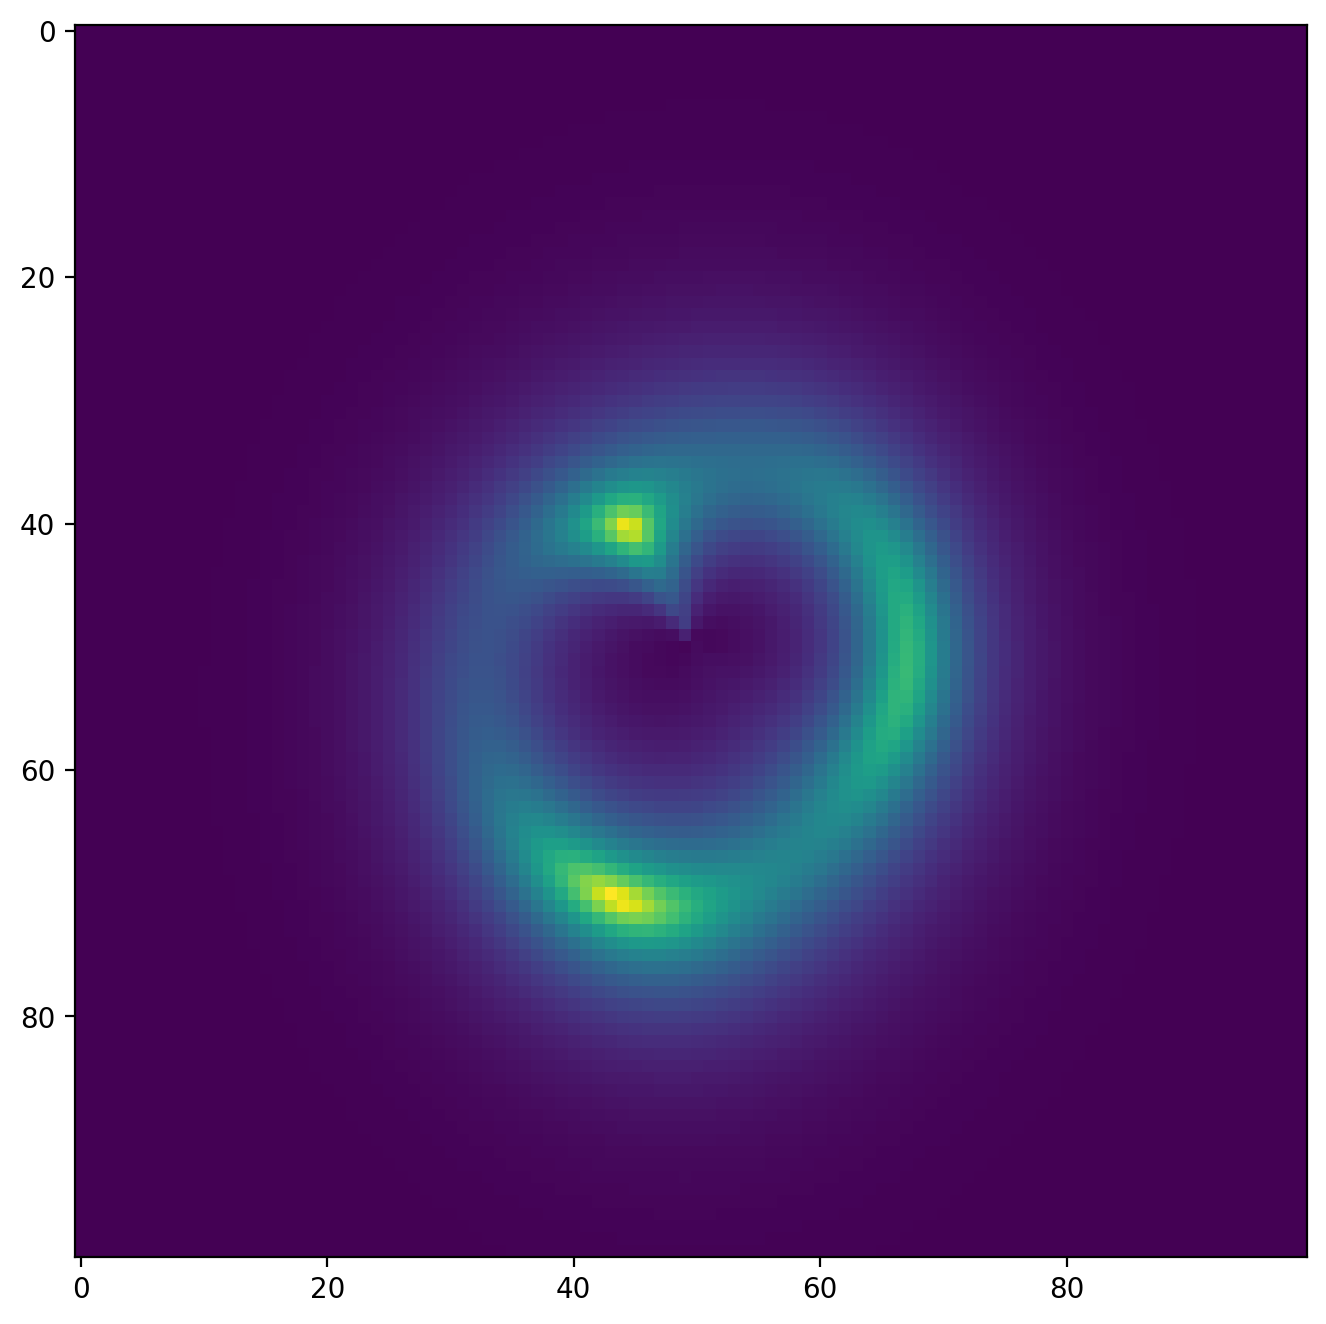

In [7]:
from stronglensing import StrongLensingSim, make_r_coor

# lens parameters
lensCat_a = {}
lensCat_a['LENSID']  = 0
lensCat_a['VELDISP'] = 200.0 # velocity dispersion of the lens, km/s
lensCat_a['XLENS']   = 0.0   # angular position of the lens, arcsec
lensCat_a['YLENS']   = 0.0   # angular position of the lens, arcsec
lensCat_a['ZLENS']   = 0.5   # redshift of the lens
lensCat_a['ELLIP']   = 0.3   # ellipticity of the lens
lensCat_a['PHIE']    = 37/180*np.pi # position angule of the lens, rad
lensCat_a['RCORE']   = 0.0   # core size of the lens, arcsec
lensCat_a['GAMMA']   = 0.05  # external shear
lensCat_a['PHIG']    =-28/180*np.pi # position angle of the external shear, rad
lensCat_a['EXTKAPPA']= 0.0   # external convergence 

# source parameters
srcsCat_a = {}
srcsCat_a['ZSRC']    = 1.0   # redshift of the source
srcsCat_a['XSRC']    = 0.03  # angular position of the source, arcsec
srcsCat_a['YSRC']    = 0.15  # angular position of the source, arcsec
srcsCat_a['ASRC']    = 0.3   # major axis of the effective radius of the source, arcsec
srcsCat_a['BSRC']    = 0.2   # minor axis of the effective radius of the source, arcsec
srcsCat_a['PHIS']    = 77/180.*jnp.pi # position angle of the source, rad
srcsCat_a['SINDEX']  = 1.1 

# meshgrids
dsx = 0.03    # pixel size
nnn = 100     # number of pixels perside of the box
bsz = dsx*nnn # box size of the field of view
xi1, xi2 = make_r_coor(bsz, nnn)

test_a = StrongLensingSim(xi1, xi2, lensCat_a, srcsCat_a)
print(test_a.lensed_images.shape)

test_a.visualize_lensed_images()

In [8]:
def forward_lensing(obs_img=None, e_obs_img=None):
    """
    Hyper-Parameters
    
    """
    VELDISP = numpyro.sample('VELDISP', dist.Uniform(100, 1000))
    ELLIP   = numpyro.sample('ELLIP', dist.Uniform(1e-1, 0.99))
    # ZLENS   = numpyro.sample('ZLENS', dist.Uniform(1e-1, 0.99))
    PHIE    = numpyro.sample('PHIE',  dist.Uniform(0, 1))
    
    # lens parameters
    lensCat_a = {}
    lensCat_a['LENSID']  = 0
    lensCat_a['VELDISP'] = VELDISP # velocity dispersion of the lens, km/s
    lensCat_a['XLENS']   = 0.0   # angular position of the lens, arcsec
    lensCat_a['YLENS']   = 0.0   # angular position of the lens, arcsec
    lensCat_a['ZLENS']   = 0.5  # redshift of the lens
    lensCat_a['ELLIP']   = ELLIP  # ellipticity of the lens
    lensCat_a['PHIE']    = PHIE # position angule of the lens, rad
    lensCat_a['RCORE']   = 0.0   # core size of the lens, arcsec
    lensCat_a['GAMMA']   = 0.05  # external shear
    lensCat_a['PHIG']    = -28/180*jnp.pi # position angle of the external shear, rad
    lensCat_a['EXTKAPPA']= 0.0   # external convergence 

    """fix the source parameter"""
    # source parameters
    srcsCat_a = {}
    srcsCat_a['ZSRC']    = 1.0   # redshift of the source
    srcsCat_a['XSRC']    = 0.03  # angular position of the source, arcsec
    srcsCat_a['YSRC']    = 0.15  # angular position of the source, arcsec
    srcsCat_a['ASRC']    = 0.3   # major axis of the effective radius of the source, arcsec
    srcsCat_a['BSRC']    = 0.2   # minor axis of the effective radius of the source, arcsec
    srcsCat_a['PHIS']    = 77/180.*jnp.pi # position angle of the source, rad
    srcsCat_a['SINDEX']  = 1.1 

    # meshgrids
    dsx = 0.03    # pixel size
    nnn = 100     # number of pixels perside of the box
    bsz = dsx*nnn # box size of the field of view
    xi1, xi2  = make_r_coor(bsz, nnn)
    lens_model = numpyro.deterministic("model",
                                        StrongLensingSim(xi1, xi2, lensCat_a, srcsCat_a).lensed_images)
    # Compute the log-likelihood
    log_like = dist.Normal(lens_model, 1).log_prob(obs_img).sum()
    numpyro.factor("log_like", log_like)


In [ ]:
# # Set the model using vmap
# vmodel = vmap(forward_lensing,)

# # Set the model using pmap
# pmodel = pmap(forward_lensing,)

kernel = NUTS(
    forward_lensing,
    target_accept_prob=0.9,
    # init_strategy=init_to_value(values=opt),
)
mcmc = MCMC(
    kernel,
    num_warmup=2000,
    num_samples=2000,
    # num_chains=4,
    progress_bar=True,
    # chain_method="vectorized",
)
rng_key = jax.random.PRNGKey(824)

noise = 1e-2*random.normal(rng_key, (test_a.lensed_images.shape), )

mcmc.run(rng_key, obs_img=test_a.lensed_images+noise)
samples = mcmc.get_samples()

mcmc.print_summary()

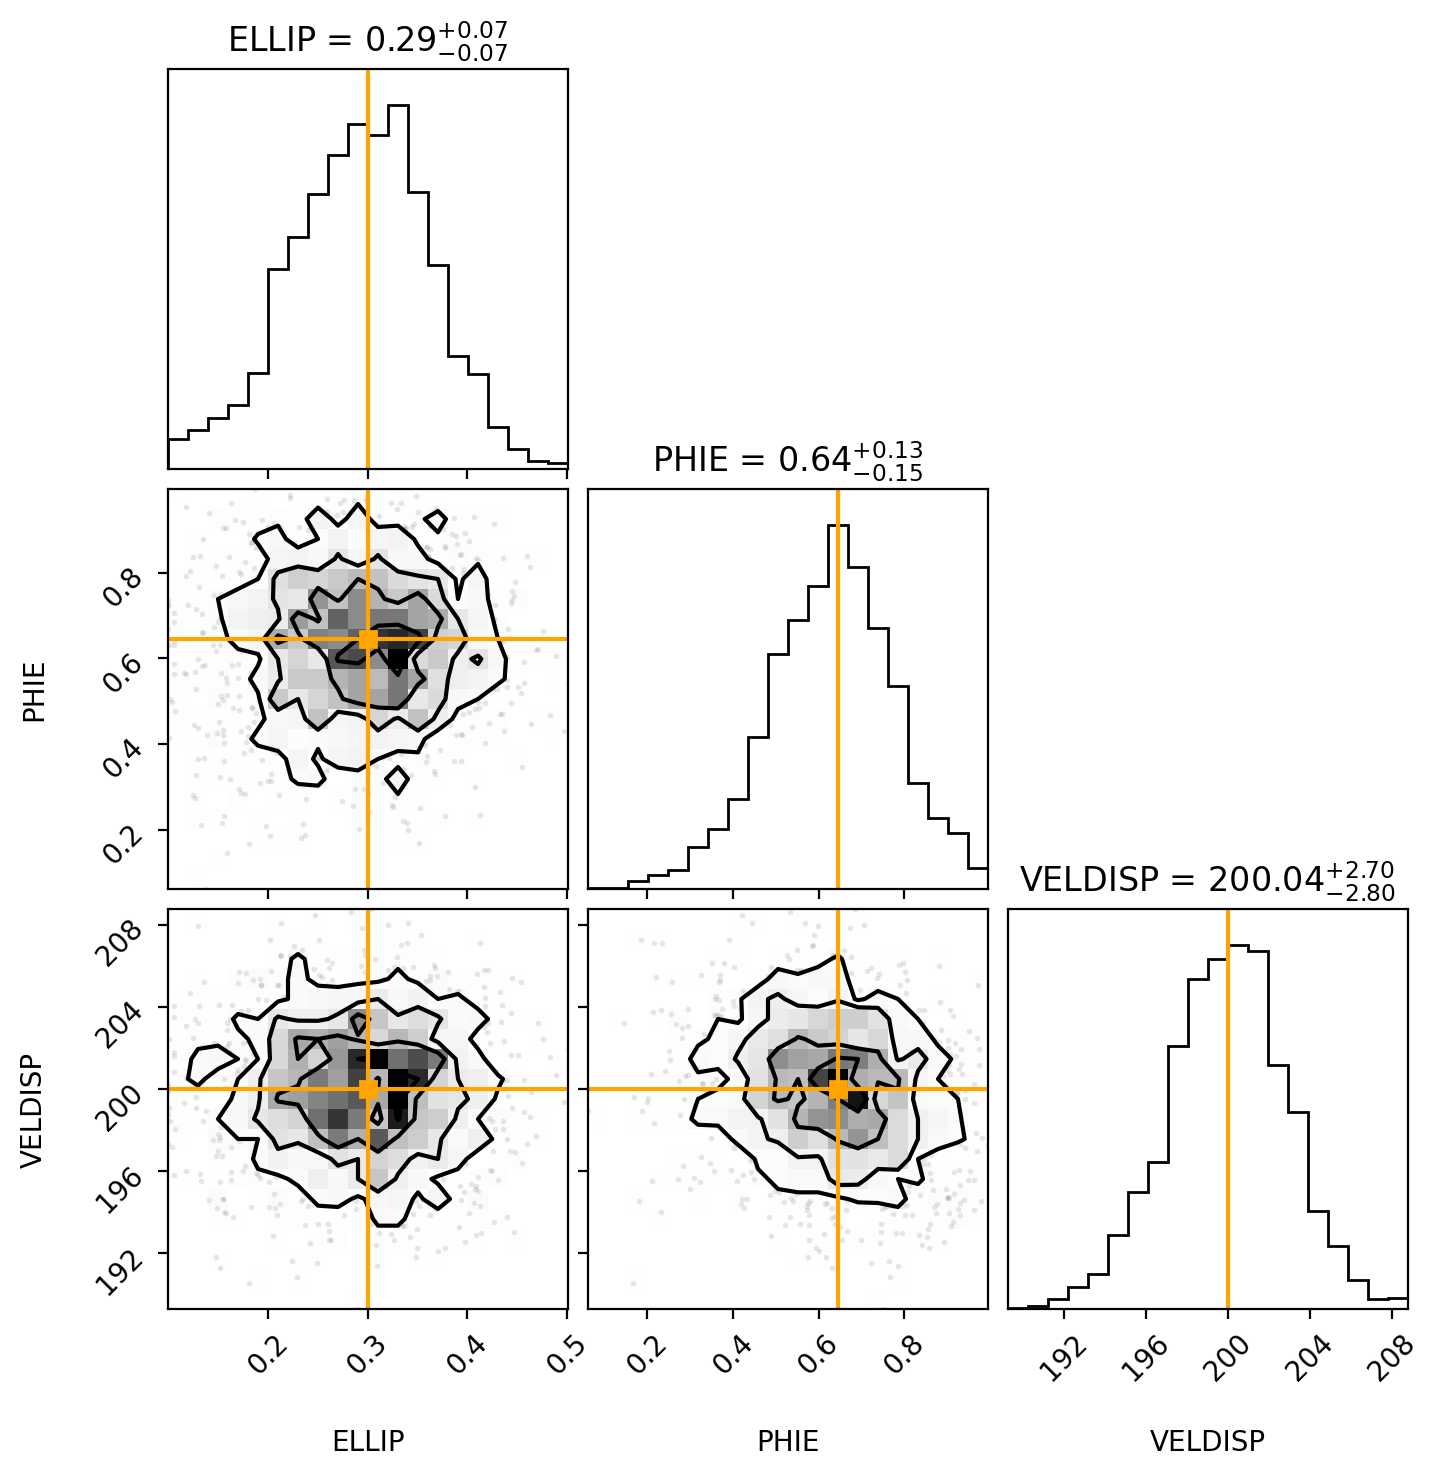

In [32]:
param_nms = ['VELDISP', 'ELLIP', 'PHIE']

# smp = np.c_[[samples[l] for l in param_nms]].T


data = az.from_dict(
    posterior={key: value for key, value in samples.items() if key in param_nms},
)

figure = corner.corner(data,
                      truths=[0.3,  37/180*np.pi, 200],
                       truth_color='orange', 
                       # labels=[r'$\Delta J_z$', r'$\Gamma$', r'$J_{z,0}$'],
                       # labels=param_nms,
                       show_titles=True)

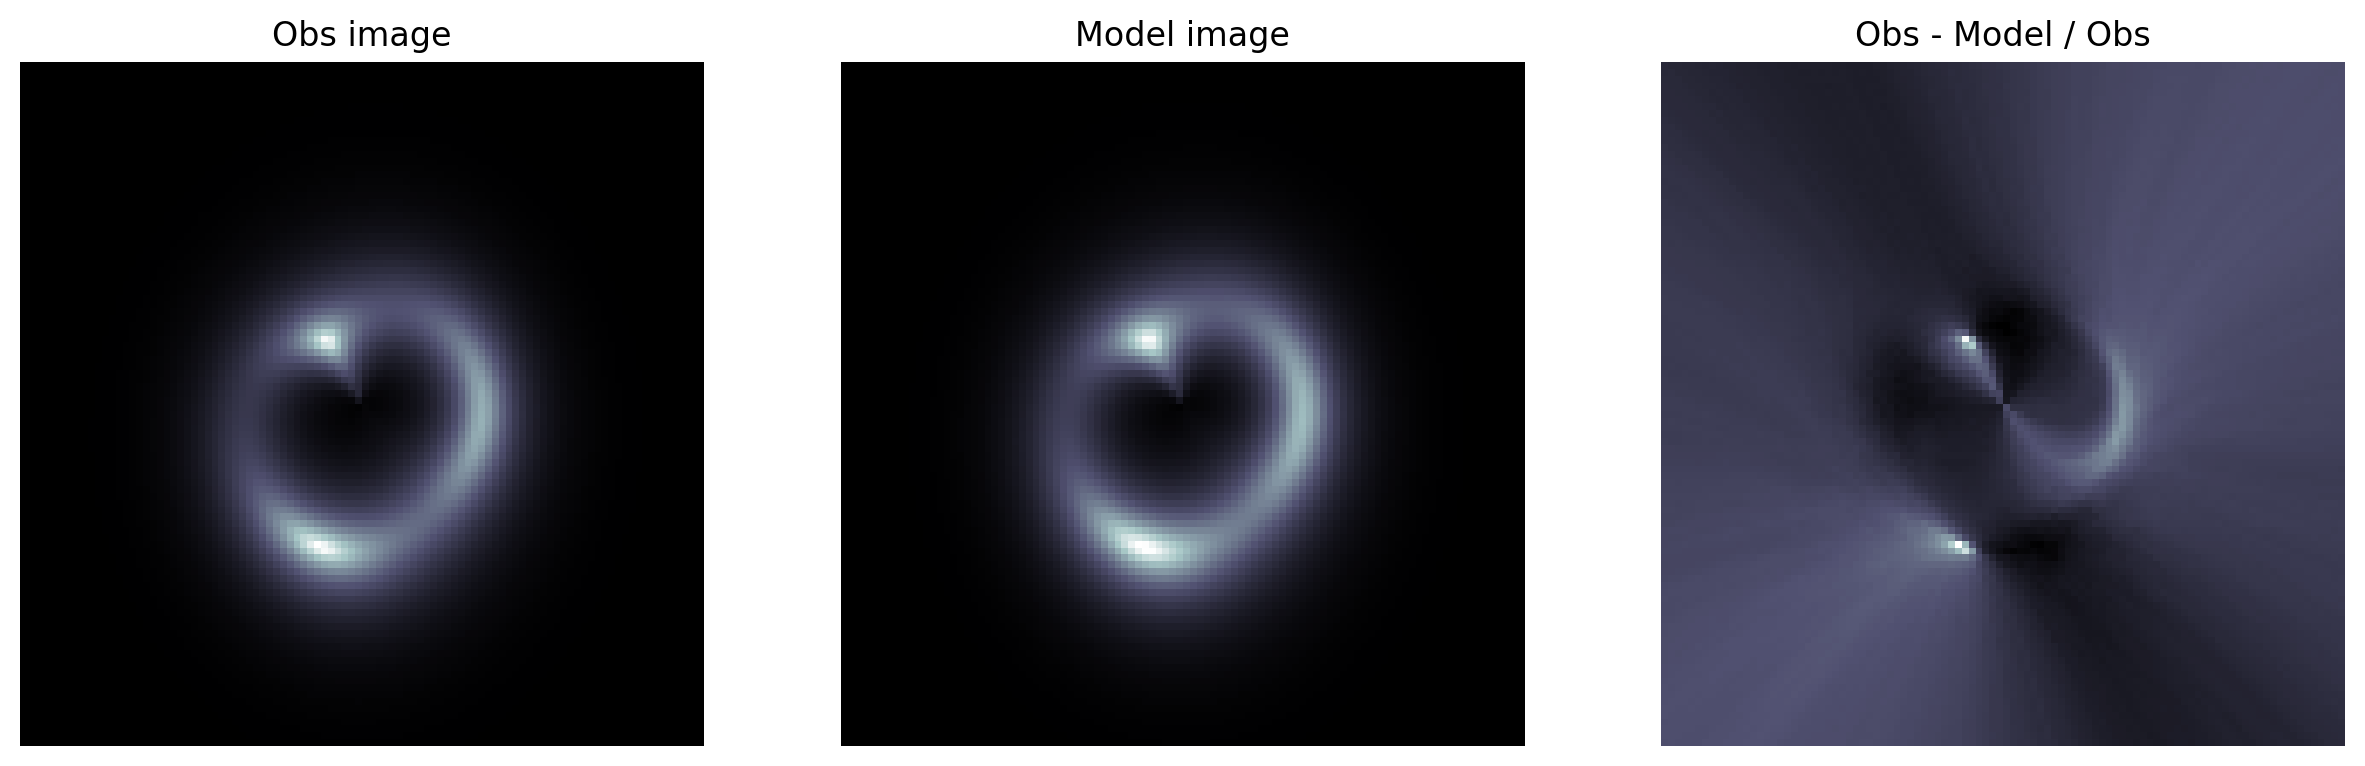

In [33]:
def plot_compare(img1, img2, cmap='bone'):
    
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    ax1, ax2, ax3 = axs.ravel()
    
    for ax in axs.ravel():
        ax.axis('off')
        
    ax1.imshow(img1, cmap=cmap)
               # norm=colors.LogNorm(vmin=0.1))
    ax1.set_title("Obs image");
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title("Model image");
    ax3.imshow((img1-img2)/img1, cmap=cmap)
    ax3.set_title("Obs - Model / Obs");

    return fig, axs

fig, axs = plot_compare(test_a.lensed_images, np.median(samples['model'], axis=0), )